### Compound chemical feature prediction using regression methods

This tutorial explores a dataset that contains LogP values and compound structure information.

We will first explore the data and generate additional descriptors. This will help us to better capture the chemical space features. In addition, we will also encode each compound using a RDkit fingerprint. Following this we will assess if LogP can be predicted using different regression methods and regularization techniques. We will aim to model LogP based on physicochemical and structural features. 

As an additional analytical point, we will explore how we can select certain physicochemical features more effectively. Such analyses typically help assess the most relevant parameters.

This example will also explore dimentionality reduction, base functions and simple pipelines. Feature selection and Lasso regularization will be used to demonstrate different menthods for feature selection. However, the chemical space feature selection is not always straightforward. Different methods can typically lead to different feature selection.

Please note this is a high-level example to demonstrate some of the modelling capabilities and basic EDA. For a more streamlined approach, you would usually need to package your analyses into modules or classes to increase reusability and reproducibility. Moreover, you would also need to include various different analytical approaches, such as diverse fingerprint testing, compound characteristics analyses, base models, etc.

In [16]:
#Import libraries
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem,PandasTools, Descriptors, Draw

from sklearn.preprocessing import StandardScaler,LabelEncoder,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso,LinearRegression,Ridge,BayesianRidge,ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

In [18]:
#Helper functions

def modelling_summary(model,y_test,y_pred,p):
    """
    Function takes model, features, test and predicted data to generate summaries.
    #Arguments
        model, model obj - fitted model
        y_test, list/array - test data 
        y_pred, list/array - predicted data
        p, int - predictor paramater number 
    #Returns
        MSE, MEA, R2 score, R2 adjusted
    """
    if len(y_test)!=len(y_pred):
        raise ValueError('Test and predicted datasets do not match')
    if not isinstance(p,int):
        raise ValueError('Parameter number is not an integer')    
    
    R2=r2_score(y_test,y_pred)
    n=len(y_test)

    R2_adj=None
    if n>p:
        R2_adj=1-(1-R2)*(n-1)/(n-p-1)
    
    print ('MSE',mean_squared_error(y_test,y_pred),'\n')
    print ('MAE',mean_absolute_error(y_test,y_pred),'\n')
    print ('R2',R2,'\n')
    if R2_adj is not None:
        print ('R2 adjusted',R2_adj,'\n')
    return

def reg_plot(y_test,y_pred):
    """
    Function plots a distribution between test and predicted datasets.
    #Arguments

        y_test, list/array - test data 
        y_pred, list/array - predicted data

    #Returns
        Regression plot and R2 value
    """
    if len(y_test)!=len(y_pred):
        raise ValueError('Test and predicted datasets do not match')

    R2=r2_score(y_test,y_pred)

    sns.regplot(x=y_test,y=y_pred,scatter_kws={'alpha':0.25})
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.title(f"R2 {R2}")
    plt.show()
    return


In [19]:
#Import data

#We are going to use CHEMBL small molecule phase 3 and 4 data

data=pd.read_table("./Data/LogP_data.csv",sep=',')
data.columns=['ID','LogP','ESOL','SMILES']
data.head()

,ID,LogP,ESOL,SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [20]:
#Prepare data
PandasTools.AddMoleculeColumnToFrame(data,smilesCol='SMILES',molCol='RMol')

#Add hidrogens to MOL for future analyses
data['RMolH']=data.RMol.apply(lambda x: Chem.AddHs(x))
#Add molecular descriptors

data["MW"]=data.RMolH.apply(lambda x: Descriptors.ExactMolWt(x))
data["TPSA"]=data.RMolH.apply(lambda x: Chem.rdMolDescriptors.CalcTPSA(x))
data["AromaticRings"]=data.RMolH.apply(lambda x: Chem.rdMolDescriptors.CalcNumAromaticRings(x))
data["nRB"]=data.RMolH.apply(lambda x: Descriptors.NumRotatableBonds(x))
data["HBA"]=data.RMolH.apply(lambda x: Descriptors.NumHAcceptors(x))
data["HBD"]=data.RMolH.apply(lambda x: Descriptors.NumHDonors(x))
data["LogP"]=data.RMolH.apply(lambda x: Descriptors.MolLogP(x))

In [21]:
data.head()

,ID,LogP,ESOL,SMILES,RMol,RMolH,MW,TPSA,AromaticRings,nRB,HBA,HBD
0,"1,1,1,2-Tetrachloroethane",2.5954,-2.794,ClCC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x0000011E559...,<rdkit.Chem.rdchem.Mol object at 0x0000011E6E3...,165.891061,0.0,0,0,0,0
1,"1,1,1-Trichloroethane",2.3765,-2.232,CC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x0000011E6E4...,<rdkit.Chem.rdchem.Mol object at 0x0000011E6E3...,131.930033,0.0,0,0,0,0
2,"1,1,2,2-Tetrachloroethane",2.5938,-2.549,ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x0000011E6E4...,<rdkit.Chem.rdchem.Mol object at 0x0000011E6E3...,165.891061,0.0,0,1,0,0
3,"1,1,2-Trichloroethane",2.0289,-1.961,ClCC(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x0000011E6A6...,<rdkit.Chem.rdchem.Mol object at 0x0000011E6E3...,131.930033,0.0,0,1,0,0
4,"1,1,2-Trichlorotrifluoroethane",2.9189,-3.077,FC(F)(Cl)C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x0000011E6A6...,<rdkit.Chem.rdchem.Mol object at 0x0000011E6E3...,185.901768,0.0,0,1,0,0


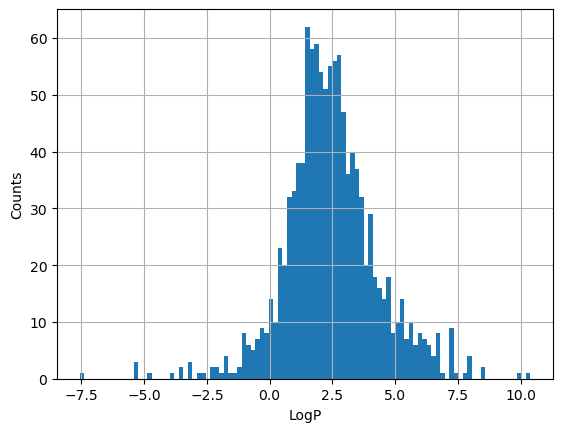

In [11]:
#Explore data

data.LogP.hist(bins=100)
plt.xlabel('LogP')
plt.ylabel('Counts')
plt.show()


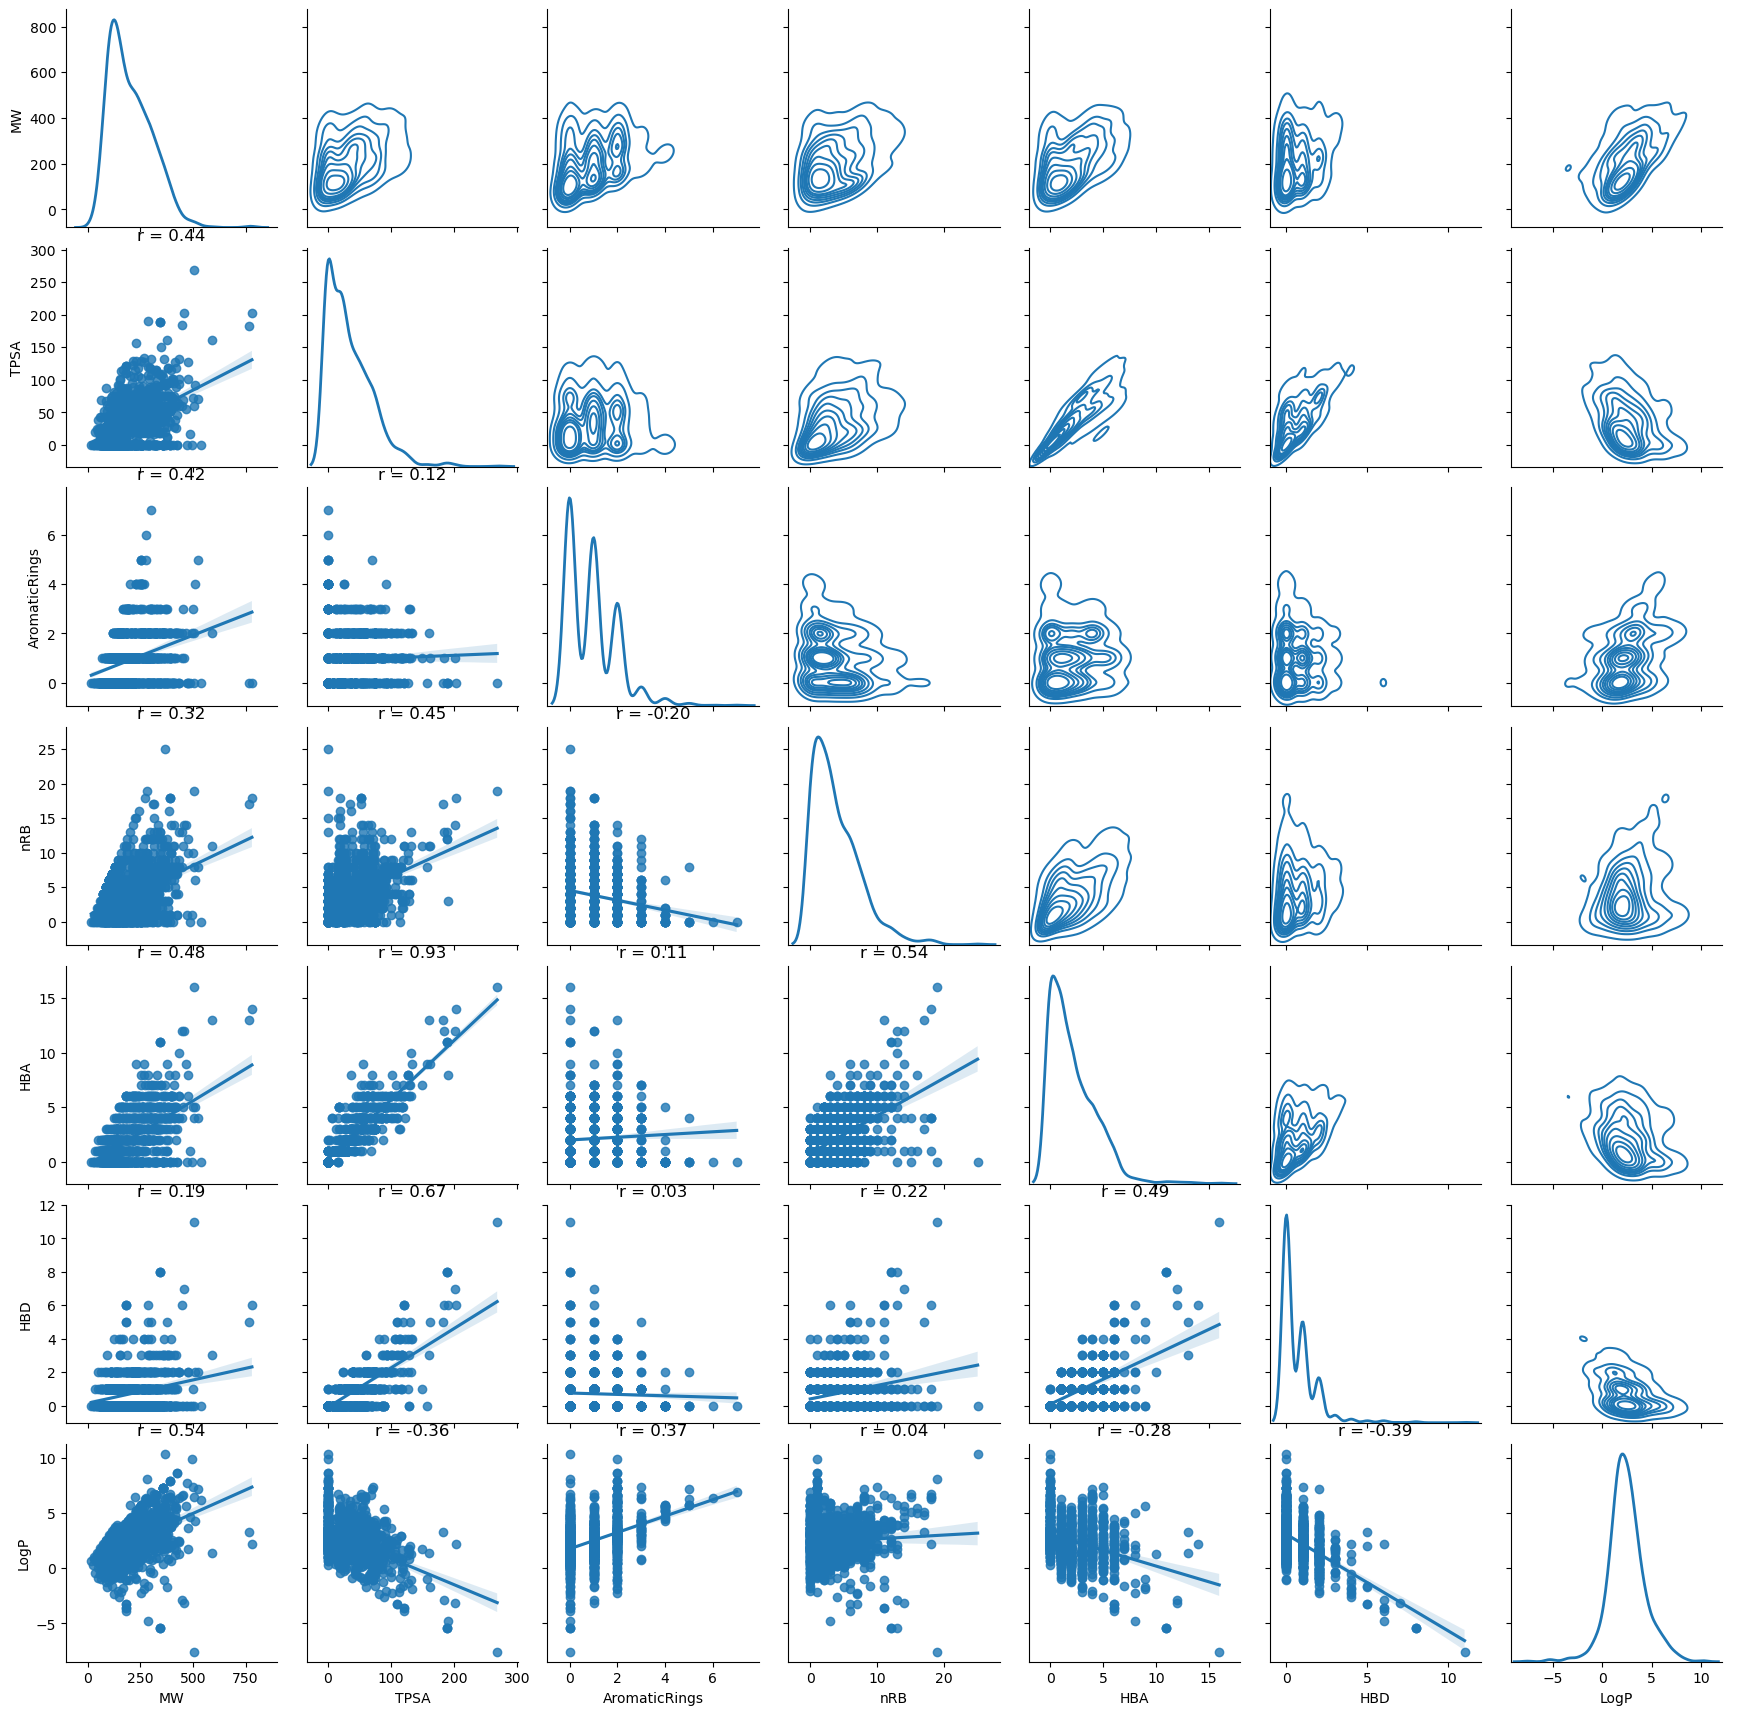

In [12]:
from scipy.stats import spearmanr
def corr(x,y,**kwargs):
    
    r,p=spearmanr(x,y)
    plt.title(f'r = {r:.2f}')
    
    return

p = sns.PairGrid(data[['MW', 'TPSA', 'AromaticRings',  'nRB', 'HBA', 'HBD', 'LogP']], palette=['blue','red','green','orange','grey','lightblue'], diag_sharey=False)
p.map_lower(sns.regplot)
p.map_upper(sns.kdeplot)
p.map_diag(sns.kdeplot, lw=2)
p.map_lower(corr)
p.add_legend()
plt.show()

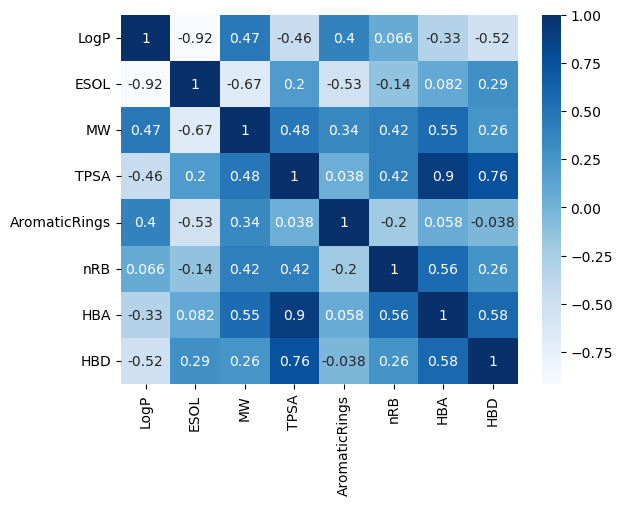

In [13]:
sns.heatmap(data.corr(),annot=True,cmap='Blues',fmt='.2g')
plt.show()

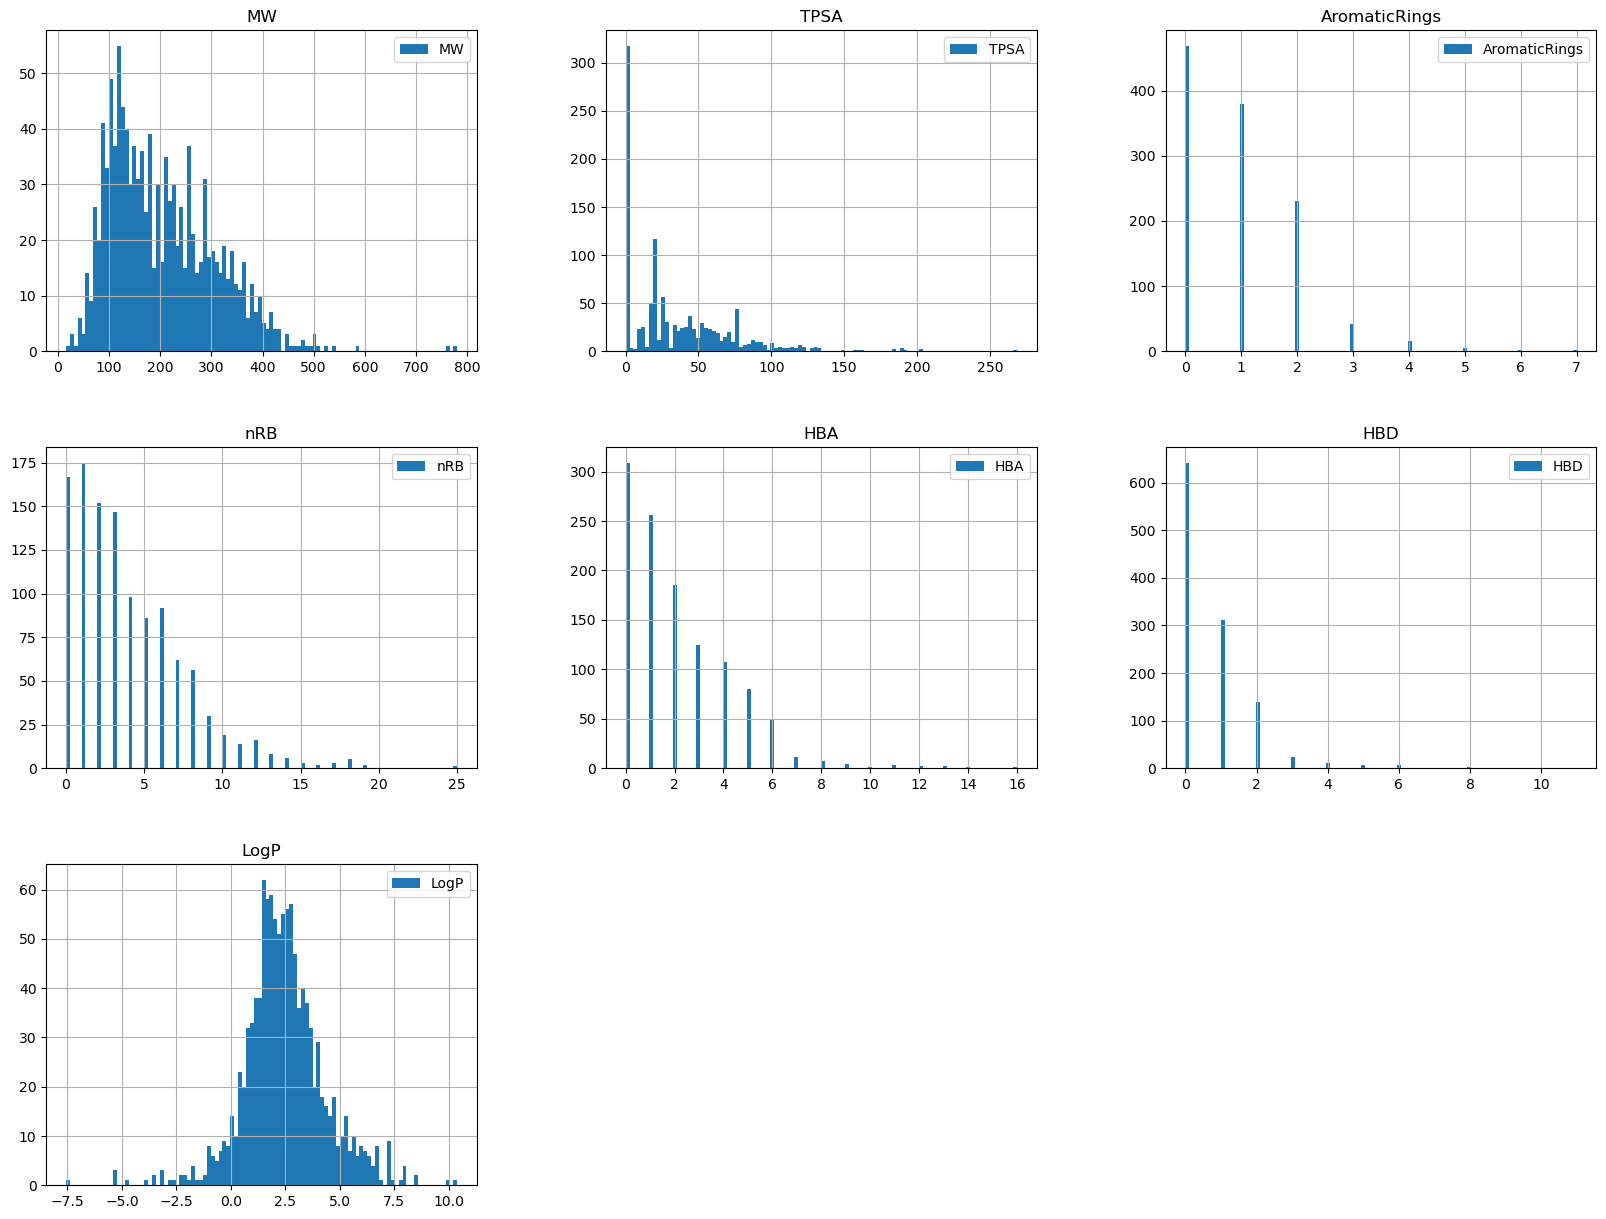

In [14]:

#In addition you can explore individual distributions to better understand how data points are distributed and capture potential outliers
data[['MW', 'TPSA', 'AromaticRings',  'nRB', 'HBA', 'HBD', 'LogP']].hist(bins=100,figsize=(20, 15), legend=True)
plt.show()

In [24]:
#Prepare data for training using compound parameters
#We are going to focus on physicochemical features to predict bioactivities
features=['MW', 'TPSA', 'AromaticRings',  'nRB', 'HBA', 'HBD']
X=data[features]
y=data['LogP']


X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.2,random_state=0)
train_idx=X_train.index.to_list()
test_idx=X_test.index.to_list()
#Scale data
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [25]:
#Fingerprint based classification

#Add fingerprint infomration
data['MorganFP']=data.RMol.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x,radius=2,nBits=1024)) #H is not important for a similarity structure search
X_fp=data['MorganFP']
#Convert into array
X_fp=[list(i) for i in X_fp]

X_train_fp=np.array(X_fp)[train_idx]

X_test_fp=np.array(X_fp)[test_idx]

[(0.40770859342512683, 'MW'), (0.49904973625148247, 'TPSA'), (0.002307170187835134, 'AromaticRings'), (0.06377483096649253, 'nRB'), (0.013430921303717128, 'HBA'), (0.013728747865345859, 'HBD')]
MSE 1.0558688858473062 

MAE 0.7205840057831483 

R2 0.6925658410245974 



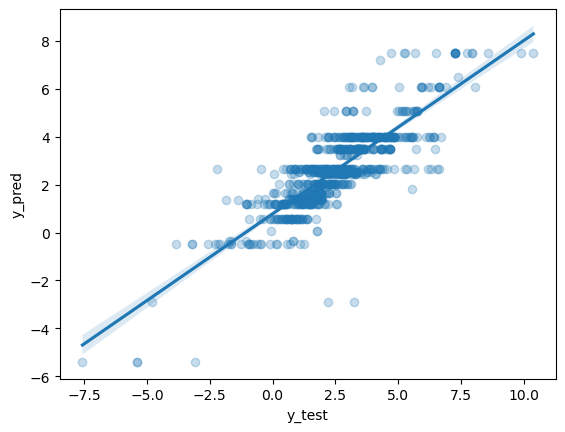

In [26]:
#Before modelling let's explore what features might be the most important

#Decision trees are extremely useful as they provide an interpretable method to
#capture important features

model=DecisionTreeRegressor(max_depth=5,criterion='squared_error')
model.fit(X_train,y_train)

y_pred=model.predict(X_test)

print(list(zip(model.feature_importances_,features)))
print ('MSE',mean_squared_error(y_test,y_pred),'\n')
print ('MAE',mean_absolute_error(y_test,y_pred),'\n')
print ('R2',r2_score(y_test,y_pred),'\n')

sns.regplot(x=y_test,y=y_pred,scatter_kws={'alpha':0.25})
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

In [27]:
#There are various methods to select and assess a relative feature importance
#One simple approach is to use SelectKBest

#Perform SelectKBest analysis

selection=SelectKBest(k=5,score_func=f_regression)
selection.fit(X_train,y_train)

print(list(zip(selection.scores_,np.round(selection.pvalues_,3),features)))

[(68.77777124695804, 0.0, 'MW'), (64.42196676745115, 0.0, 'TPSA'), (48.21457326448744, 0.0, 'AromaticRings'), (0.03115755176195351, 0.86, 'nRB'), (31.342673624794088, 0.0, 'HBA'), (94.77357412020147, 0.0, 'HBD')]


Decision trees used squared error to capture the most relevant features, while SelectKBest relied on F-statistic. We can see that both appraches put a high importance on MW and TPSA.

For the analysis we will use all parameters; however, some further fine tuning is always required when preparing an actual model to select the best parameters that offer the most stability and the best generalisation.

MSE 3.3667947116244084 

MAE 1.3461023749478094 

R2 0.0197005381208204 

R2 adjusted 0.013229914610066729 



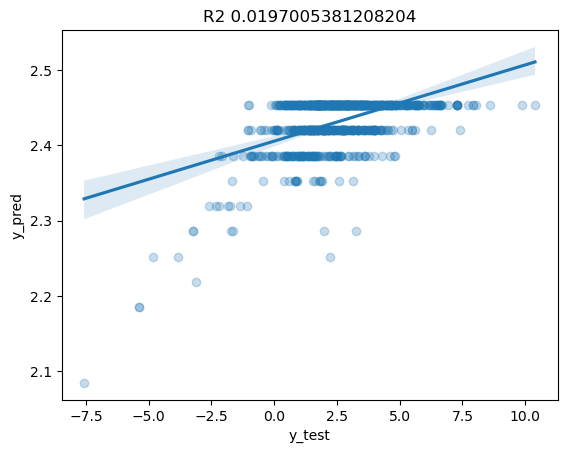

In [56]:
#Perform Lasso modelling
model=Lasso()
model.fit(X_train,y_train)

y_pred=model.predict(X_test)

#Assess model performance
modelling_summary(model,y_test,y_pred,len(features))
reg_plot(y_test,y_pred)

In [57]:
#Explore how LASSO performs feature selection
print(list(zip(features,np.abs(model.coef_))))


[('MW', 0.0), ('TPSA', 0.0), ('AromaticRings', 0.0), ('nRB', 0.0), ('HBA', 0.0), ('HBD', 0.039446897999098444)]


MSE 0.37712217402151244 

MAE 0.465380676045108 

R2 0.8901944739964184 

R2 adjusted 0.8894696850458997 



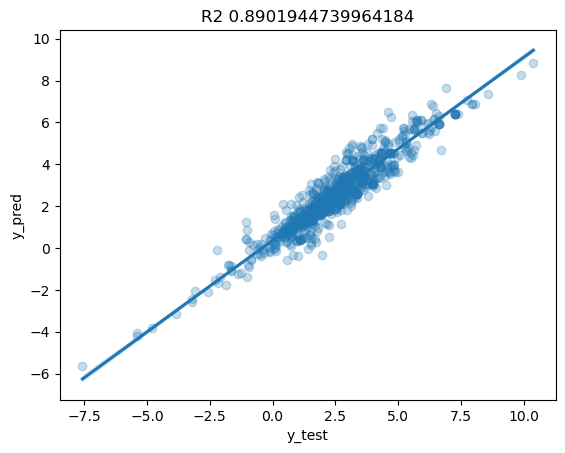

In [39]:
#Perform Ridge modelling
model=Ridge()
model.fit(X_train,y_train)

y_pred=model.predict(X_test)

#Assess model performance
modelling_summary(model,y_test,y_pred,len(features))
reg_plot(y_test,y_pred)

In [40]:
#Explore how Ridge performs feature selection
print(list(zip(features,np.abs(model.coef_))))

[('MW', 1.4215157830740541), ('TPSA', 0.3887860809741676), ('AromaticRings', 0.4465374647606479), ('nRB', 0.46008666171666696), ('HBA', 1.059029410530972), ('HBD', 0.5313895268385365)]


MSE 0.37728510024996936 

MAE 0.46528228064120464 

R2 0.8901470352578666 

R2 adjusted 0.8894219331803608 



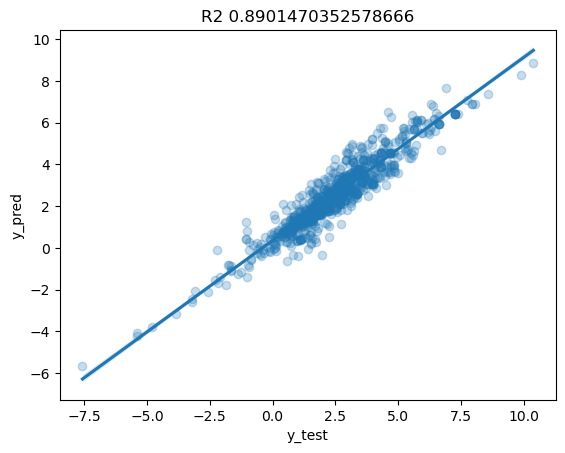

In [42]:
#Perform BayesRidge modelling
model=BayesianRidge()
model.fit(X_train,y_train)

y_pred=model.predict(X_test)

#Assess model performance
modelling_summary(model,y_test,y_pred,len(features))
reg_plot(y_test,y_pred)

In [43]:
#Explore how BayesRidge performs feature selection
print(list(zip(features,np.abs(model.coef_))))

[('MW', 1.4270642151562702), ('TPSA', 0.3748569424611138), ('AromaticRings', 0.4469038261980221), ('nRB', 0.46388834983328836), ('HBA', 1.077033923908215), ('HBD', 0.5346259326418228)]


MSE 1.3470279957094882 

MAE 0.8511820222098 

R2 0.6077899211463678 

R2 adjusted 0.6052010757413933 



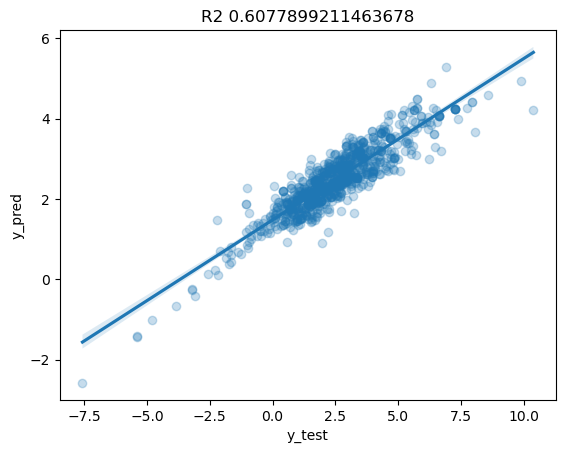

In [83]:
#Perform ElasticNet modelling
model=ElasticNet(l1_ratio=0.1)
model.fit(X_train,y_train)

y_pred=model.predict(X_test)

#Assess model performance
modelling_summary(model,y_test,y_pred,len(features))
reg_plot(y_test,y_pred)

MSE 0.3987625757815984 

MAE 0.43848324455942256 

R2 0.8838935034837179 

R2 adjusted 0.8831271239687589 



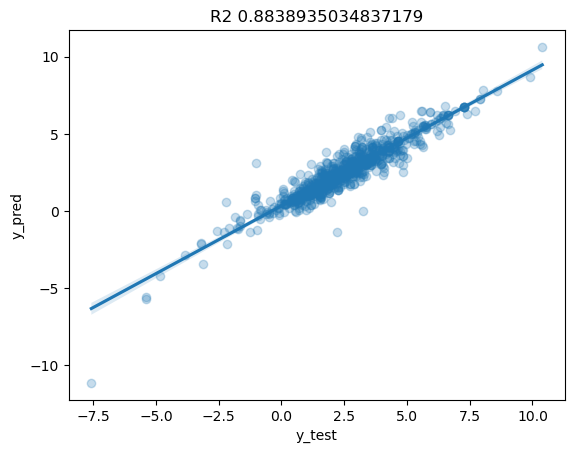

In [84]:
#Create a pipeline for polynomial basis function
pipeline=make_pipeline(PolynomialFeatures(degree=2, include_bias=False),Ridge())

pipeline.fit(X_train,y_train)


y_pred=pipeline.predict(X_test)

#Assess model performance
modelling_summary(pipeline,y_test,y_pred,len(features))
reg_plot(y_test,y_pred)

MSE 0.3871401417577978 

MAE 0.4668718846100631 

R2 0.8872775725449885 

R2 adjusted 0.886533530119543 



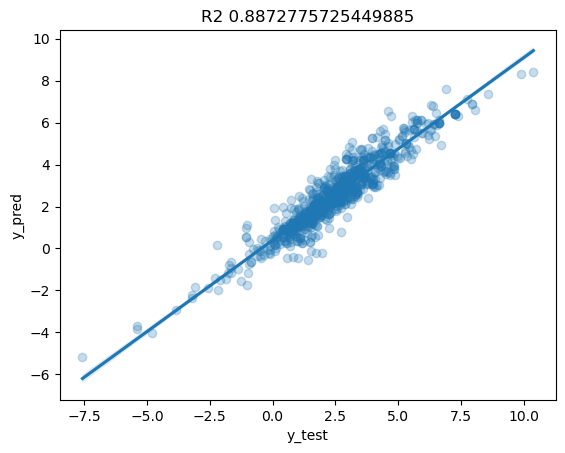

In [85]:
#Create a pipeline for PCA
pipeline=make_pipeline(PCA(0.95),Ridge())

pipeline.fit(X_train,y_train)


y_pred=pipeline.predict(X_test)

#Assess model performance
modelling_summary(pipeline,y_test,y_pred,len(features))
reg_plot(y_test,y_pred)

MSE 0.7134552137462846 

MAE 0.6333490732384015 

R2 0.7922653972053639 

R2 adjusted 0.7908942117083696 



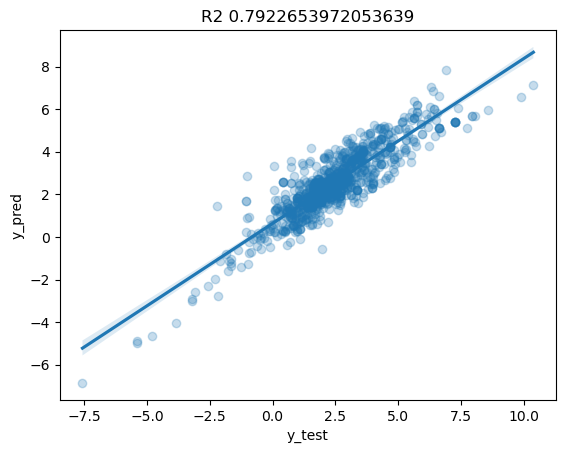

In [86]:
#Create a pipeline for PCA
pipeline=make_pipeline(PCA(n_components=3),Ridge())

pipeline.fit(X_train,y_train)


y_pred=pipeline.predict(X_test)

#Assess model performance
modelling_summary(pipeline,y_test,y_pred,len(features))
reg_plot(y_test,y_pred)

MSE 2.675339613172737 

MAE 1.1857106700505817 

R2 0.22102943369780914 

R2 adjusted 0.2184670305191836 



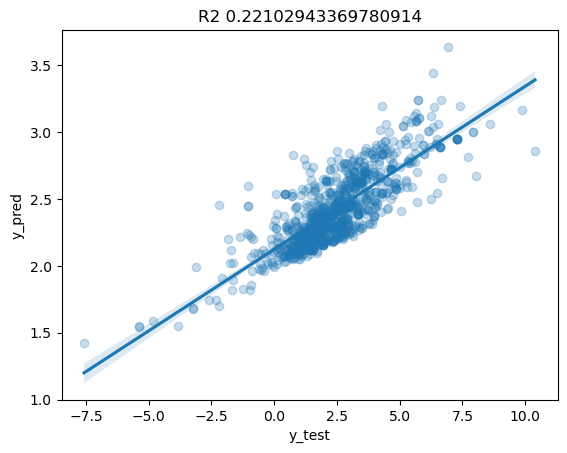

In [55]:
#Create a pipeline for PCA
pipeline=make_pipeline(PCA(n_components=3),Lasso())

pipeline.fit(X_train,y_train)


y_pred=pipeline.predict(X_test)

#Assess model performance
modelling_summary(pipeline,y_test,y_pred,pipeline.steps[0][1].n_components)
reg_plot(y_test,y_pred)

MSE 12.067135852549953 

MAE 1.3856356117053283 

R2 -2.5135515515201194 

R2 adjusted -2.6326549939445303 



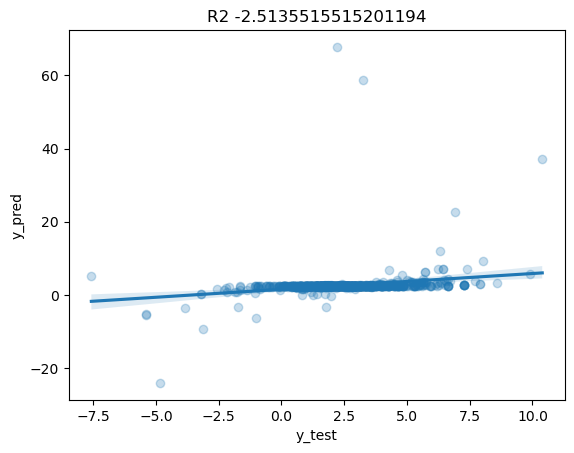

In [61]:
#Create a pipeline for PCA
pipeline=make_pipeline(PolynomialFeatures(degree=5),Lasso())

pipeline.fit(X_train,y_train)


y_pred=pipeline.predict(X_test)

#Assess model performance
modelling_summary(pipeline,y_test,y_pred,len(features)*5)
reg_plot(y_test,y_pred)

### Fingerprint based classification

Comparing how physicochemical and structural data can influence predictions for LogP

In [61]:
#Select training data that matches earlier so that we can compare more effectively
X_train_fp=np.array(X_fp)[train_idx]

X_test_fp=np.array(X_fp)[test_idx]

MSE 1.1901994965809084 

MAE 0.7830758397591904 

R2 0.6534532022404771 

R2 adjusted 1.279867890511883 



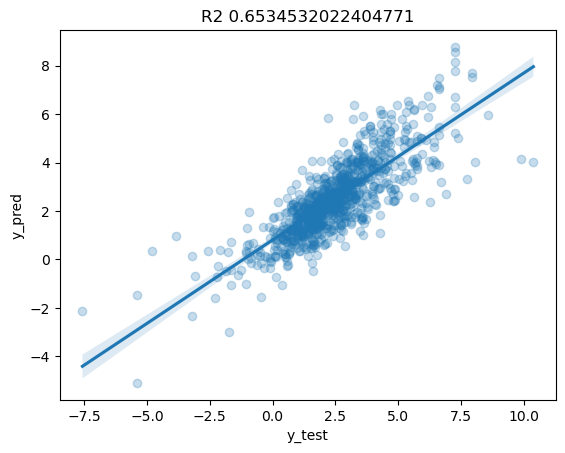

In [87]:
#Perform Ridge modelling
model=Ridge()
model.fit(X_train_fp,y_train)

y_pred=model.predict(X_test_fp)

#Assess model performance
modelling_summary(model,y_test,y_pred,2048)
reg_plot(y_test,y_pred)

MSE 3.4352659979891143 

MAE 1.3558467667394478 

R2 -0.0002360398195409008 

R2 adjusted 9.396476848026422 



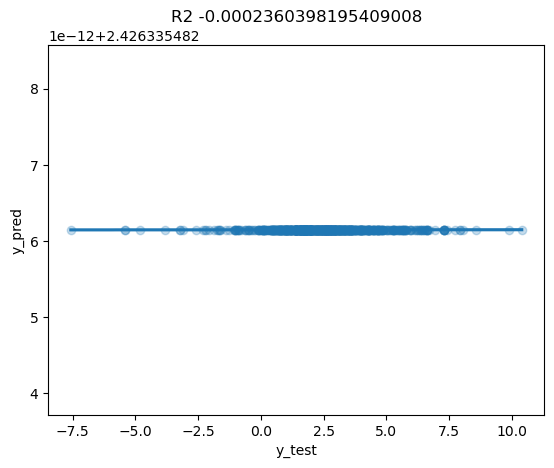

In [88]:
#Perform Lasso modelling
model=Lasso()
model.fit(X_train_fp,y_train)

y_pred=model.predict(X_test_fp)

#Assess model performance
modelling_summary(model,y_test,y_pred,1024)
reg_plot(y_test,y_pred)

MSE 2.5654871024969417 

MAE 1.1661809068808053 

R2 0.253014857914423 

R2 adjusted 0.2489105439469198 



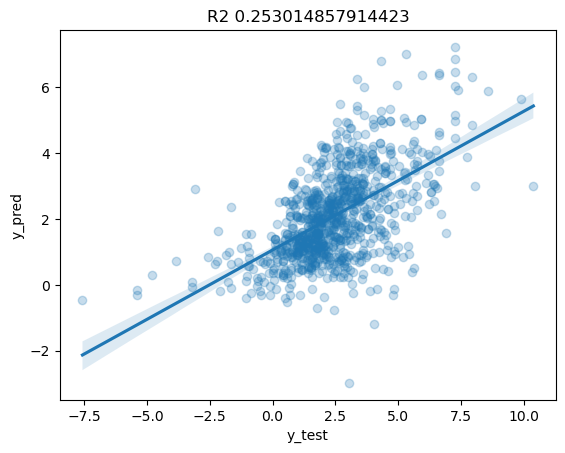

In [96]:
#Create a pipeline for polynomial basis function
pipeline=make_pipeline(PCA(n_components=5),PolynomialFeatures(degree=3, include_bias=False),Ridge())

pipeline.fit(X_train_fp,y_train)


y_pred=pipeline.predict(X_test_fp)

#Assess model performance
modelling_summary(pipeline,y_test,y_pred,5)
reg_plot(y_test,y_pred)